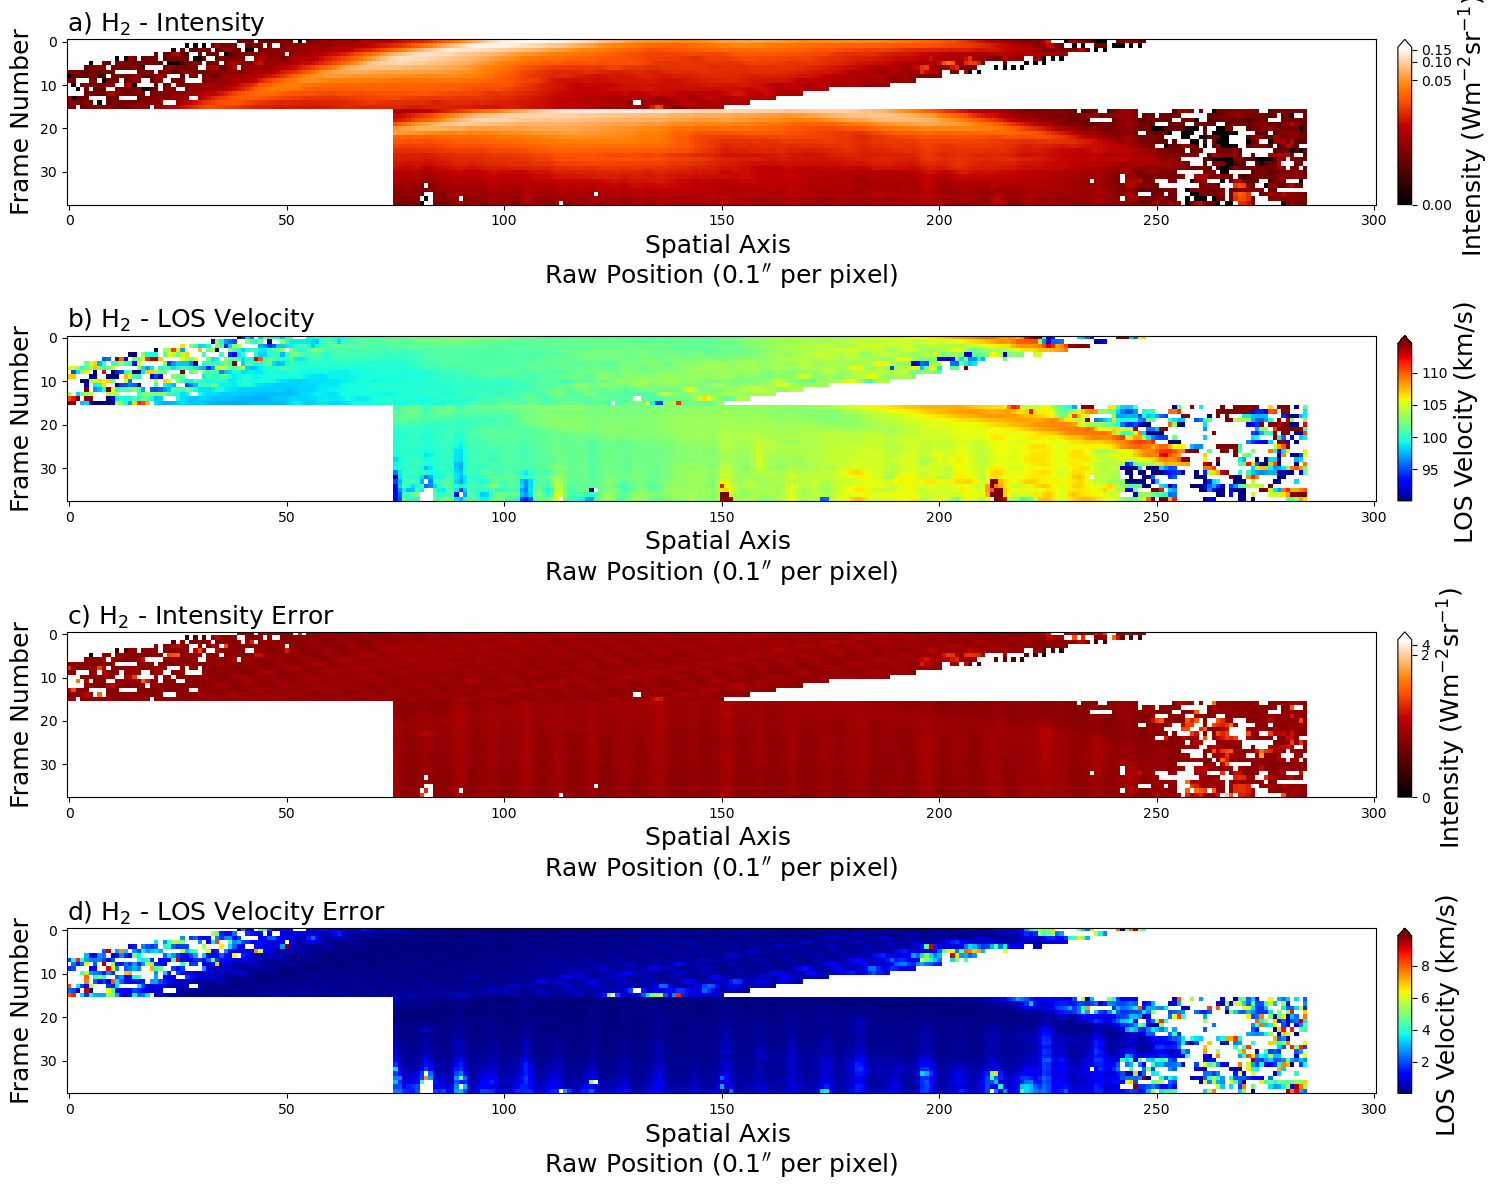

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from astropy.io import fits
from matplotlib.colors import PowerNorm, LogNorm
from lmfit import Model, fit_report
from lmfit.models import LinearModel

h2_int_shifted = fits.open('h2_int_shifted.fits', ignore_missing_end=True)[0].data
h2_los_shifted = fits.open('h2_los_shifted.fits', ignore_missing_end=True)[0].data
h2_int_shifted_error = fits.open('h2_int_shifted_error.fits', ignore_missing_end=True)[0].data
h2_los_shifted_error = fits.open('h2_los_shifted_error.fits', ignore_missing_end=True)[0].data

fig = plt.figure(figsize=(22,12), tight_layout=True)

fig.add_subplot(411)
plt.imshow(h2_int_shifted, cmap='gist_heat', norm=PowerNorm(gamma=0.2))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_2$ - Intensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

fig.add_subplot(412)
plt.imshow(h2_los_shifted, cmap='jet')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('b) H$_2$ - LOS Velocity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='LOS Velocity (km/s)',size=18)

fig.add_subplot(413)
plt.imshow(h2_int_shifted_error, cmap='gist_heat', norm=PowerNorm(gamma=0.1))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('c) H$_2$ - Intensity Error', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

fig.add_subplot(414)
plt.imshow(h2_los_shifted_error, cmap='jet')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('d) H$_2$ - LOS Velocity Error', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='LOS Velocity (km/s)',size=18)

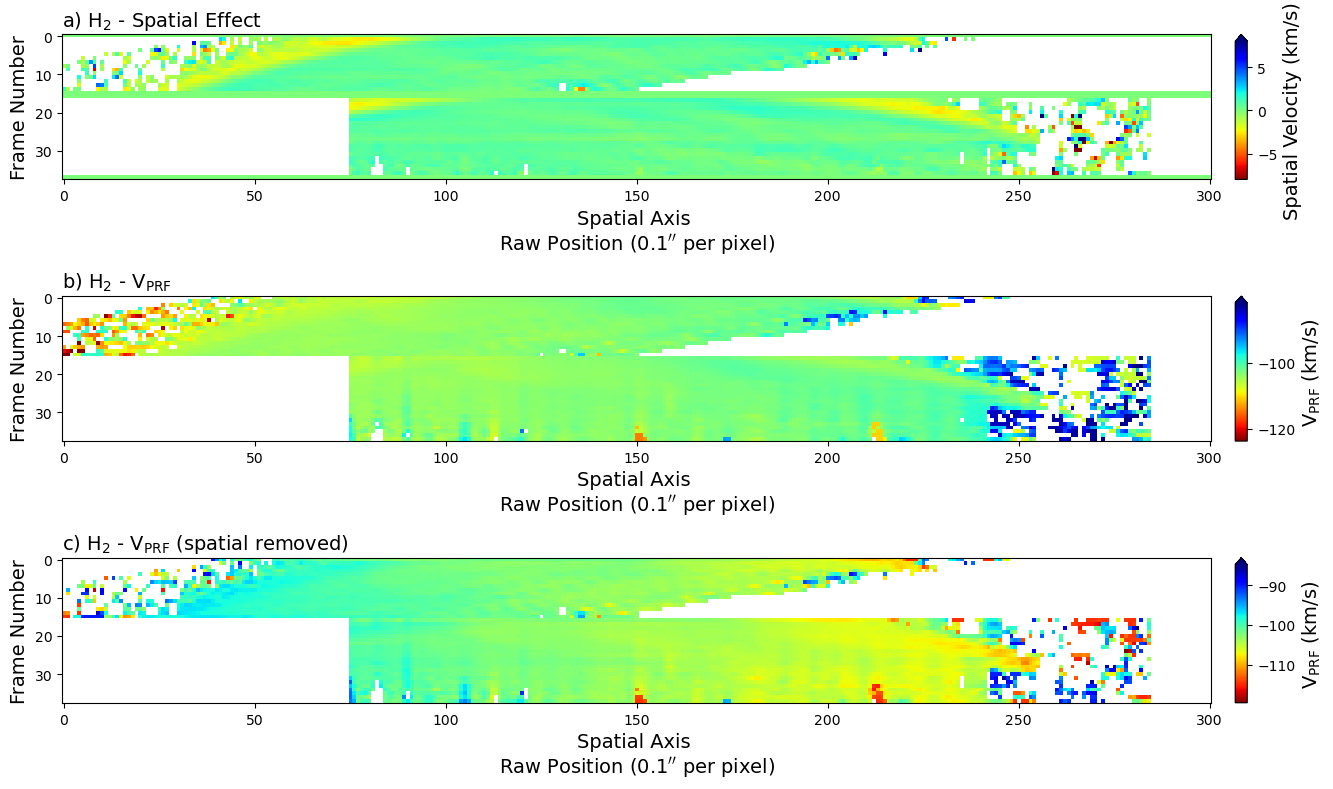

In [4]:
ang_diam = 40.58867
ang_diam/(0.1)
limb_vel = 12.572
vel_slope = limb_vel * 2 / (ang_diam/(0.1))

x = np.linspace(0,300,301)
rot_rate = vel_slope * x
rot_rate = rot_rate - rot_rate[150]

h2_plan_vel = h2_los_shifted + 0

for i in range(np.size(h2_los_shifted, 0)):
    h2_plan_vel[i,:] = h2_los_shifted[i,:] - rot_rate


spatial_velocity = h2_los_shifted + 0
spatial_velocity[::] = 0

for i in range(np.size(spatial_velocity, 1)):
    for j in range(1, np.size(spatial_velocity, 0)-1):
        if j not in (15,16):
            y = np.arange(3)
            p = np.array((h2_int_shifted[j-1][i], h2_int_shifted[j][i], h2_int_shifted[j+1][i]))
#             print(j,i)
    #         plt.figure()
    #         plt.plot(y, p, 'k.', label='original')
            f = scipy.interpolate.interp1d(y,p)
            xnew = np.linspace(0,2,7)
    #         plt.figure()
    #         plt.plot(xnew, f(xnew), 'r.', label='interpolate')
    #         plt.legend()
    #         print(f(xnew[2]), f(xnew[4]))
            p1 = f(xnew[2])
            p3 = f(xnew[4])
            di = (p3 - p1)/(p3 + p1)
            dv = 7.99*di

            if np.isreal(dv):
                spatial_velocity[j,i] = dv

h2_corrected_vel = h2_los_shifted-spatial_velocity
# h2_corrected_vel = h2_plan_vel-spatial_velocity # use this for vprf

fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(311)
plt.imshow(spatial_velocity*(-1), cmap='jet_r')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel('Frame Number', fontsize=14)
plt.title('a) H$_2$ - Spatial Effect', loc='left', fontsize=14)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Spatial Velocity (km/s)',size=14)

fig.add_subplot(312)
plt.imshow(h2_plan_vel*(-1), cmap='jet_r')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel('Frame Number', fontsize=14)
plt.title('b) H$_2$ - V$_{\mathrm{PRF}}$', loc='left', fontsize=14)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='V$_{\mathrm{PRF}}$ (km/s)',size=14)

fig.add_subplot(313)
plt.imshow(h2_corrected_vel*(-1), cmap='jet_r')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel('Frame Number', fontsize=14)
plt.title('c) H$_2$ - V$_{\mathrm{PRF}}$ (spatial removed)', loc='left', fontsize=14)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='V$_{\mathrm{PRF}}$ (km/s)',size=14)

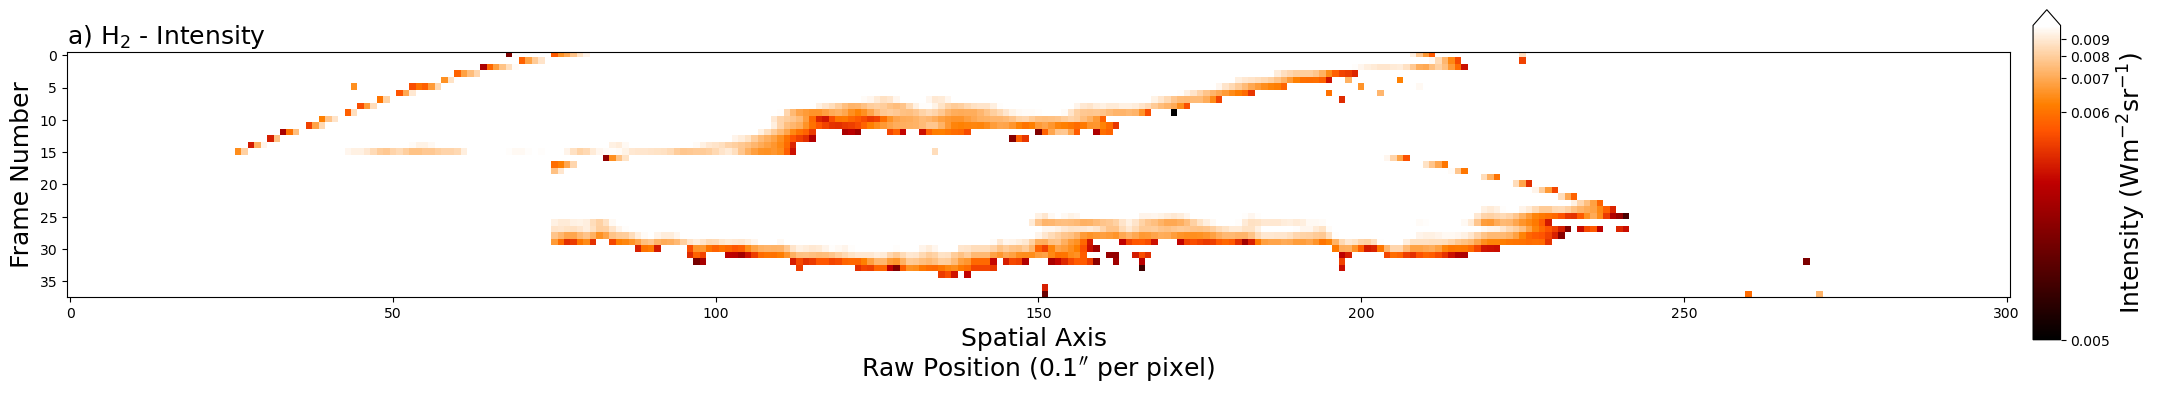

In [6]:
h2_bright2 = h2_int_shifted + 0
h2_bright2[h2_int_shifted > 0.01] = np.nan
h2_bright2[h2_int_shifted < 0.005] = np.nan

fig = plt.figure(figsize=(24,4), tight_layout=True)

fig.add_subplot(111)
plt.imshow(h2_bright2, cmap='gist_heat', norm=PowerNorm(gamma=0.2))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_2$ - Intensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

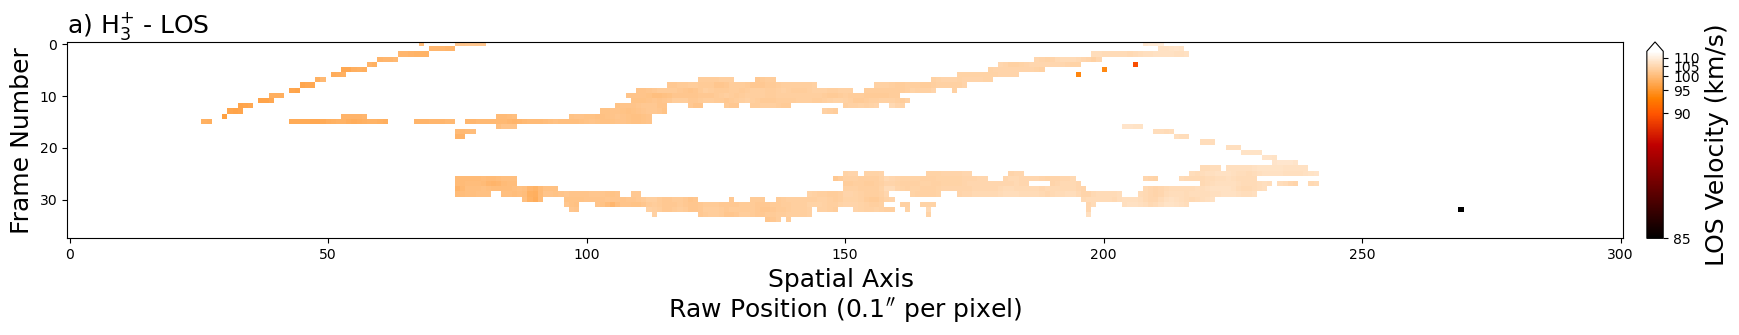

In [8]:
los_vel4 = h2_corrected_vel + 0
los_vel4[h2_los_shifted_error > 3] = np.nan
los_vel4[np.isnan(h2_bright2)] = np.nan

# los_vel4[los_vel4 < 80] = np.nan
# los_vel4[los_vel4 > 88] = np.nan
# los_vel4[:,:85] = np.nan
# los_vel4[:,232:] = np.nan


fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(313)
plt.imshow(los_vel4, cmap='gist_heat', norm=PowerNorm(gamma=0.2))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_3^{+}$ - LOS', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='LOS Velocity (km/s)',size=18)

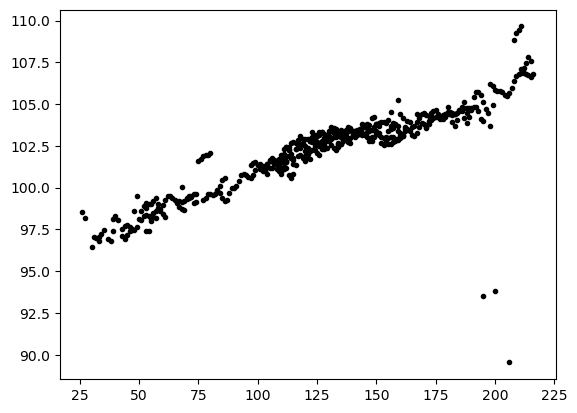

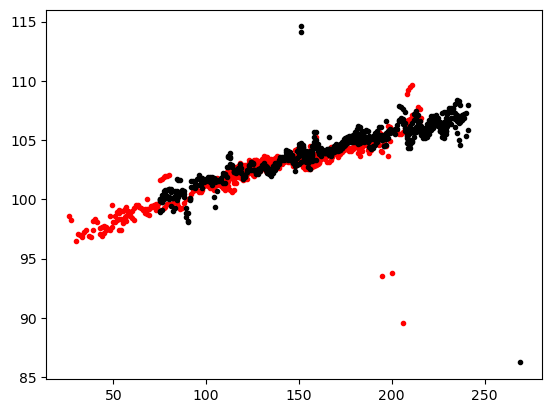

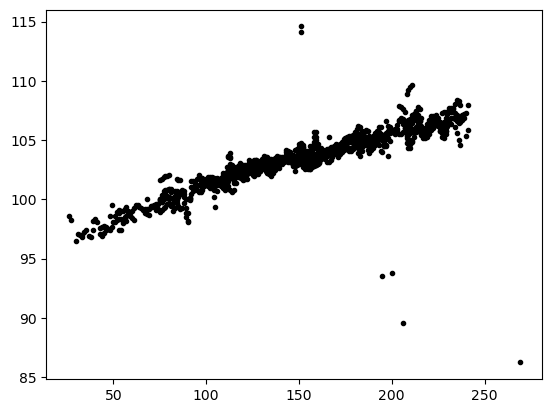

In [9]:
arr = los_vel4 + 0
for i in range(0,300):
    arr[:,i] = i
xt = arr[:16][np.isfinite(los_vel4[:16])]
vt = los_vel4[:16][np.isfinite(los_vel4[:16])]

xb = arr[16:][np.isfinite(los_vel4[16:])]
vb = los_vel4[16:][np.isfinite(los_vel4[16:])]

x = arr[:][np.isfinite(los_vel4[:])]
v = los_vel4[:][np.isfinite(los_vel4[:])]

plt.figure()
plt.plot(xt,vt, 'k.')
# plt.vlines(150, ymin=72, ymax=95, color='b')
# plt.hlines(83.8, xmin=0, xmax=300)

plt.figure()
plt.plot(xt,vt, 'r.')
plt.plot(xb, vb, 'k.')
# plt.vlines(150, ymin=82, ymax=85, color='b')

plt.figure()
plt.plot(x, v, 'k.')

103.28399295258214
0.16672584760195502


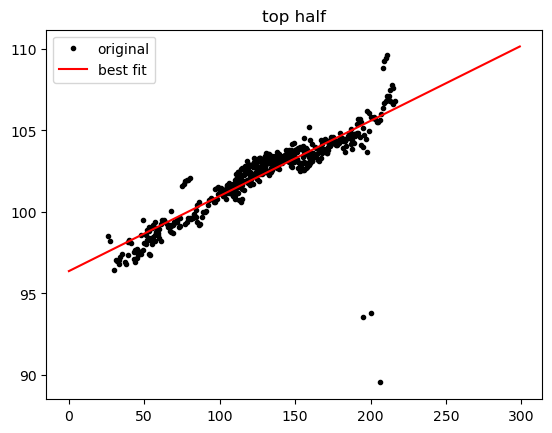

In [10]:
arr = los_vel4 + 0
for i in range(0,300):
    arr[:,i] = i
xt = arr[:16][np.isfinite(los_vel4[:16])]
vt = los_vel4[:16][np.isfinite(los_vel4[:16])]

mod = LinearModel()

pars = mod.guess(vt, x=xt)
out = mod.fit(vt, pars, x=xt)

mt = out.params['slope'].value
bt = out.params['intercept'].value
sig_mt = out.params['slope'].stderr
sig_bt = out.params['intercept'].stderr

# x_fit = np.linspace(110,219,110)
xtf = np.linspace(0,299,300)
vtf = mt * xtf + bt
vterr = np.sqrt(sig_mt**2 + sig_bt**2)

plt.figure()
plt.plot(xt, vt,'.k', label = 'original')
plt.plot(xtf, vtf, 'r', label = 'best fit')
plt.title('top half')
plt.legend()

print(vtf[np.where(xtf==150)][0])
print(vterr)

103.48813765828974
0.16434662826692414


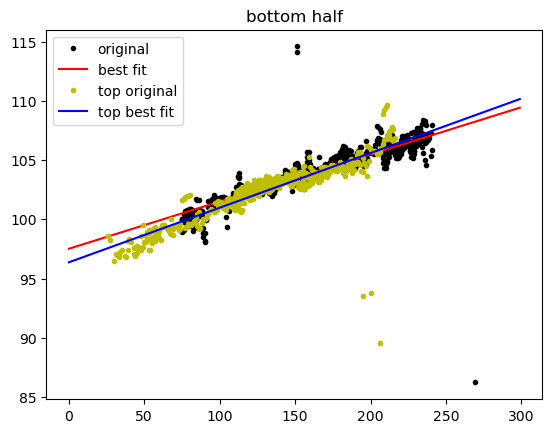

In [11]:
arr = los_vel4 + 0
for i in range(0,300):
    arr[:,i] = i
xb = arr[16:][np.isfinite(los_vel4[16:])]
vb = los_vel4[16:][np.isfinite(los_vel4[16:])]

mod = LinearModel()

pars = mod.guess(vb, x=xb)
out = mod.fit(vb, pars, x=xb)

mb = out.params['slope'].value
bb = out.params['intercept'].value
sig_mb = out.params['slope'].stderr
sig_bb = out.params['intercept'].stderr

# x_fit = np.linspace(110,219,110)
xbf = np.linspace(0,299,300)
vbf = mb * xbf + bb
vberr = np.sqrt(sig_mb**2 + sig_bb**2)

plt.figure()
plt.plot(xb, vb,'.k', label = 'original')
plt.plot(xbf, vbf, 'r', label = 'best fit')
plt.plot(xt, vt,'.y', label = 'top original')
plt.plot(xtf, vtf, 'b', label = 'top best fit')
# plt.ylim(80,90)
plt.title('bottom half')
# plt.vlines(195, ymin=82, ymax=85, color='b')
# plt.hlines(83.8, xmin=0, xmax=300)
plt.legend()

print(vbf[np.where(xbf==150)][0])
print(vberr)

In [12]:
vtf[np.where(xtf==150)][0] - vbf[np.where(xbf==150)][0]

-0.20414470570760557

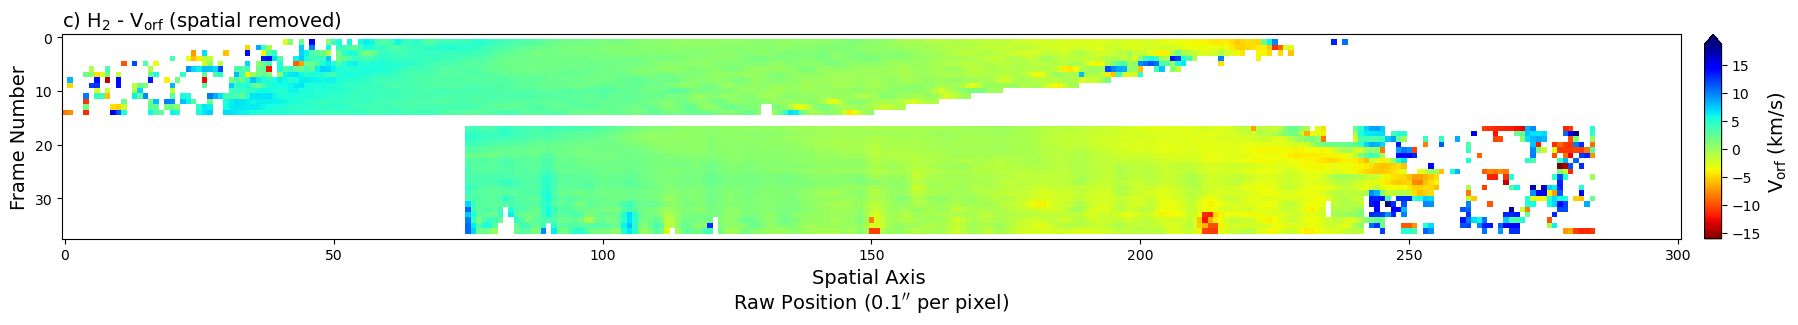

In [13]:
h2_corrected_vel_sec1 = np.delete(h2_corrected_vel, np.s_[16:], axis=0)
h2_corrected_vel_sec2 = np.delete(h2_corrected_vel, np.s_[:16], axis=0)

h2_vorf_sec1 = h2_corrected_vel_sec1 - vtf[np.where(xtf==150)][0]
h2_vorf_sec2 = h2_corrected_vel_sec2 - vbf[np.where(xbf==150)][0]

h2_vorf = np.vstack((h2_vorf_sec1, h2_vorf_sec2))
# h2_vorf[h2_vorf > 2] = 2
# h2_vorf[h2_vorf < -2] = -2
h2_vorf[0] = np.nan
h2_vorf[15] = np.nan
h2_vorf[16] = np.nan
h2_vorf[-1] = np.nan
h2_vorf[15:,:50] = np.nan

fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(313)
plt.imshow(h2_vorf*(-1), cmap='jet_r')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel('Frame Number', fontsize=14)
plt.title('c) H$_2$ - V$_{\mathrm{orf}}$ (spatial removed)', loc='left', fontsize=14)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='V$_{\mathrm{orf}}$ (km/s)',size=14)

In [14]:
h2_los_shifted_error

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype='>f8')

In [15]:
h2_los_shifted_error_sec1 = np.delete(h2_los_shifted_error, np.s_[16:], axis=0)
h2_los_shifted_error_sec2 = np.delete(h2_los_shifted_error, np.s_[:16], axis=0)

In [16]:
vterr,vberr

(0.16672584760195502, 0.16434662826692414)

In [2]:
spatial_velocity2 = h2_int_shifted * np.nan

b_err = 0.10641512039513978

for i in range(np.size(spatial_velocity2, 1)):
# for i in range(1,2):
    for j in range(1, np.size(spatial_velocity2, 0)-1):
        if j not in (15,16):
            y = np.arange(3)
            a = h2_int_shifted[j-1][i] - h2_int_shifted_error[j-1][i]
            b = h2_int_shifted[j][i]
            c = h2_int_shifted[j+1][i] + h2_int_shifted_error[j-1][i]
            p = np.array((a, b, c))
            d = h2_int_shifted[j-1][i] + h2_int_shifted_error[j-1][i]
            e = h2_int_shifted[j][i]
            f = h2_int_shifted[j+1][i] - h2_int_shifted_error[j-1][i]
            q = np.array((d, e, f))
            l = h2_int_shifted[j-1][i]
            m = h2_int_shifted[j][i]
            n = h2_int_shifted[j+1][i]
            r = np.array((l, m, n))
#             print(j,i)
#             plt.figure()
#             plt.plot(y, p, 'k', label='original')
            f1 = scipy.interpolate.interp1d(y,p)
            f2 = scipy.interpolate.interp1d(y,q)
            f = scipy.interpolate.interp1d(y,r)
            xnew = np.linspace(0,2,7)
#             plt.figure()
#             plt.plot(xnew, f(xnew), 'r.', label='interpolate')
    #         plt.legend()
#             print(f(xnew[2]), f(xnew[4]))
            p11 = f1(xnew[2])
            p31 = f1(xnew[4])
            p12 = f2(xnew[2])
            p32 = f2(xnew[4])
            p1 = f(xnew[2])
            p3 = f(xnew[4])
            di1 = (p31 - p11)/(p31 + p11)
            di2 = (p32 - p12)/(p32 + p12)
            di = (p3 - p1)/(p3 + p1)
            
#             print('di1 = '+str(di1))
#             print('di2 = '+str(di2))
            sig = (di1-di2)/2.
#             print('sig = '+str(sig))
            
            dv = 7.99*di
            dv_err = dv * np.sqrt((b_err/7.99)**2 + (sig/di)**2)
#             print('dv_err = '+str(dv_err))
#             print('dv = '+str(dv))
            if np.isreal(dv_err):
                spatial_velocity2[j,i] = dv_err

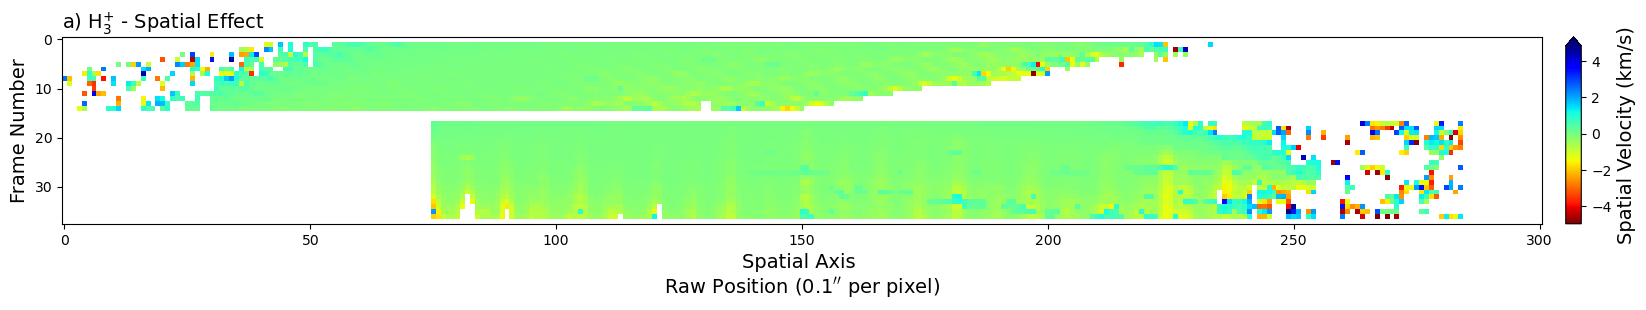

In [3]:
spatial_velocity2[spatial_velocity2 > 5] = np.nan
spatial_velocity2[spatial_velocity2 < -5] = np.nan

fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(311)
plt.imshow(spatial_velocity2, cmap='jet_r')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ylabel('Frame Number', fontsize=14)
plt.title('a) H$_3^{+}$ - Spatial Effect', loc='left', fontsize=14)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Spatial Velocity (km/s)',size=14)

In [4]:
np.nanmin(spatial_velocity2)

-4.965419467534861

In [7]:
spat_err = spatial_velocity2.copy()
spat_err

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [8]:
np.nanmin(spat_err)

-4.965419467534861

In [5]:
spat_err = fits.open('h2_spat_err.fits', ignore_missing_end=True)[0].data
spat_err

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype='>f8')

In [6]:
np.nanmin(spat_err)

-4.965419467534861

In [18]:
spat_err_sec1 = np.delete(spat_err, np.s_[16:], axis=0)
spat_err_sec2 = np.delete(spat_err, np.s_[:16], axis=0)

h2_tot_error_sec1 = np.sqrt((h2_los_shifted_error_sec1)**2 + (vterr)**2 + (spat_err_sec1)**2)
h2_tot_error_sec2 = np.sqrt((h2_los_shifted_error_sec2)**2 + (vberr)**2 + (spat_err_sec2)**2)

h2_tot_error = np.vstack((h2_tot_error_sec1, h2_tot_error_sec2))
h2_tot_error

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [19]:
hdu1 = fits.PrimaryHDU(h2_vorf)
hdu1.writeto('h2_vorf.fits', overwrite=True)

hdu2 = fits.PrimaryHDU(h2_tot_error)
hdu2.writeto('h2_vorf_err.fits', overwrite=True)